In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [21]:
#import csvs
data_1d_df = pd.read_csv(
    Path("ML Training Resources/Bored Ape 1D.csv"), 
    index_col="DateTime", 
    infer_datetime_format=True, 
    parse_dates=True
)
data_7d_df = pd.read_csv(
    Path("ML Training Resources/Bored Ape 7D.csv"), 
    index_col="DateTime", 
    infer_datetime_format=True, 
    parse_dates=True
)
data_30d_df = pd.read_csv(
    Path("ML Training Resources/Bored Ape 30D.csv"), 
    index_col="DateTime", 
    infer_datetime_format=True, 
    parse_dates=True
)

In [22]:
#averqaging data
ave_pri1_df = pd.DataFrame(data_1d_df["Sales USD"] / data_1d_df["Number of sales"])
ave_pri7_df = pd.DataFrame(data_7d_df["Sales USD"] / data_7d_df["Number of sales"])
ave_pri30_df = pd.DataFrame(data_30d_df["Sales USD"] / data_30d_df["Number of sales"])

In [23]:
#concat
signal_dfs = [ave_pri1_df,ave_pri7_df,ave_pri30_df]
signal_df = pd.concat(signal_dfs,
                     axis = 1).dropna()
signal_df.columns = ["close", "sma_fast", "sma_slow"]
signal_df['actual_returns'] = signal_df['close'].pct_change()
display(signal_df)

,close,sma_fast,sma_slow,actual_returns
DateTime,,,,
2021-12-16,87022.754598,66857.271347,67006.093783,NaN
2021-12-17,50049.003162,63904.811018,67787.709425,-0.424875
2021-12-18,57897.111481,62330.142146,67996.821959,0.156808
2021-12-19,76085.120800,63042.403229,67935.074134,0.314144
2021-12-20,50175.640109,62662.297179,68052.907267,-0.340533
...,...,...,...,...
2022-12-06,24737.349687,24314.458755,25983.150508,0.039874
2022-12-07,22885.927909,23742.282077,25525.783038,-0.074843
2022-12-08,33227.273889,25021.918433,25456.586311,0.451865


In [24]:
signal_df = signal_df.dropna()
display(signal_df)

,close,sma_fast,sma_slow,actual_returns
DateTime,,,,
2021-12-17,50049.003162,63904.811018,67787.709425,-0.424875
2021-12-18,57897.111481,62330.142146,67996.821959,0.156808
2021-12-19,76085.120800,63042.403229,67935.074134,0.314144
2021-12-20,50175.640109,62662.297179,68052.907267,-0.340533
2021-12-21,49903.796429,59049.131202,67510.037491,-0.005418
...,...,...,...,...
2022-12-06,24737.349687,24314.458755,25983.150508,0.039874
2022-12-07,22885.927909,23742.282077,25525.783038,-0.074843
2022-12-08,33227.273889,25021.918433,25456.586311,0.451865


In [25]:
X = signal_df[['sma_fast', 'sma_slow']].shift().dropna().copy()
X

,sma_fast,sma_slow
DateTime,,
2021-12-18,63904.811018,67787.709425
2021-12-19,62330.142146,67996.821959
2021-12-20,63042.403229,67935.074134
2021-12-21,62662.297179,68052.907267
2021-12-22,59049.131202,67510.037491
...,...,...
2022-12-06,23591.254892,26057.440679
2022-12-07,24314.458755,25983.150508
2022-12-08,23742.282077,25525.783038


In [26]:
#signal_df['signal'] = 0.0
#signal_df.loc[(signal_df['actual_returns'] >=0), 'signal'] = 1
#signal_df.loc[(signal_df['actual_returns'] < 0), 'signal'] = -1
#y = signal_df['signal'].copy()

In [27]:
signal_df['signal'] = 0.0
signal_df.loc[(signal_df['sma_fast'] >= signal_df['sma_slow']), 'signal'] = 1
signal_df.loc[(signal_df['sma_fast'] < signal_df['sma_slow']), 'signal'] = -1
y = signal_df['signal'].copy()

In [28]:
from pandas.tseries.offsets import DateOffset

In [29]:
training_begin = X.index.min()
training_end = X.index.min() + DateOffset(months=9)
print(training_begin)
print(training_end)

2021-12-18 00:00:00
2022-09-18 00:00:00


In [30]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]
X_train.head()

,sma_fast,sma_slow
DateTime,,
2021-12-18,63904.811018,67787.709425
2021-12-19,62330.142146,67996.821959
2021-12-20,63042.403229,67935.074134
2021-12-21,62662.297179,68052.907267
2021-12-22,59049.131202,67510.037491


In [31]:
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
X_test.head()

,sma_fast,sma_slow
DateTime,,
2022-09-18,31124.439841,34196.145026
2022-09-19,30221.479002,34312.946251
2022-09-20,29582.104620,34188.709053
2022-09-21,29479.686464,34340.009949
2022-09-22,28107.702904,33751.977738


In [32]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [33]:
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train_scaled, y_train)
training_signal_predictions = svm_model.predict(X_train_scaled)
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [34]:
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.87      0.95      0.91       152
         1.0       0.94      0.82      0.87       123

    accuracy                           0.89       275
   macro avg       0.90      0.89      0.89       275
weighted avg       0.90      0.89      0.89       275



In [35]:
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [36]:
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.73      1.00      0.84        61
         1.0       0.00      0.00      0.00        23

    accuracy                           0.73        84
   macro avg       0.36      0.50      0.42        84
weighted avg       0.53      0.73      0.61        84



In [37]:
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_signal'] = testing_signal_predictions
predictions_df['actual_returns'] = signal_df['actual_returns']
predictions_df['trading_algorithm_returns'] = (
    predictions_df['actual_returns'] * predictions_df['predicted_signal']
)
predictions_df

,predicted_signal,actual_returns,trading_algorithm_returns
DateTime,,,
2022-09-18,-1.0,0.005192,-0.005192
2022-09-19,-1.0,-0.171421,0.171421
2022-09-20,-1.0,0.093058,-0.093058
2022-09-21,-1.0,-0.295448,0.295448
2022-09-22,-1.0,0.284975,-0.284975
...,...,...,...
2022-12-06,-1.0,0.039874,-0.039874
2022-12-07,-1.0,-0.074843,0.074843
2022-12-08,-1.0,0.451865,-0.451865


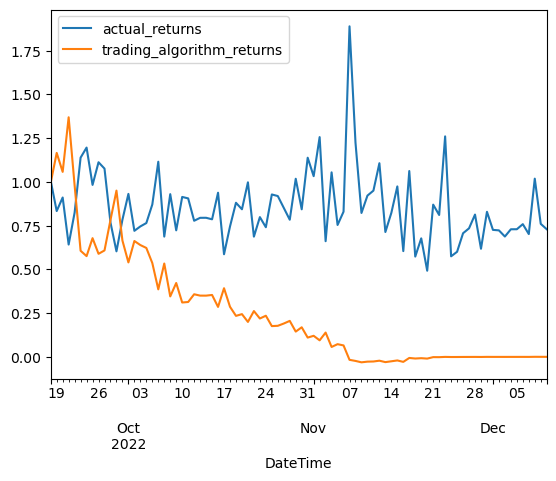

In [38]:
return_plot = (1 + predictions_df[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot()
return_plot.get_figure().savefig('strategy_returns_SL1.png')